In [17]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import pickle

In [18]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [19]:
# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2)
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])


In [20]:
# Load CIFAR-10
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=8)


Files already downloaded and verified
Files already downloaded and verified


In [21]:
# 🔹 Define Bottleneck Residual Block
class BottleneckBlock(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [22]:
# Compact Bottleneck ResNet
class CompactBottleneckResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(CompactBottleneckResNet, self).__init__()
        # ↓ Reduce initial channels to 16
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        # ↓ Use smaller out_channels [16, 32, 64, 128] with 2 blocks each
        self.layer1 = self._make_layer(block, 32, blocks=2, stride=1)
        self.layer2 = self._make_layer(block, 64, blocks=2, stride=2)
        self.layer3 = self._make_layer(block, 128, blocks=2, stride=2)
        self.layer4 = self._make_layer(block, 256, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the model
model = CompactBottleneckResNet(BottleneckBlock, num_classes=10).to(device)

In [23]:
# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Check number of parameters
num_params = count_parameters(model)
print(f"Total trainable parameters: {num_params}")
print(f"Is the model under 5M parameters? {'Yes' if num_params < 5_000_000 else 'No'}")


Total trainable parameters: 3499994
Is the model under 5M parameters? Yes


In [24]:
# Define Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

# 🔹 Cosine Learning Rate Warmup + Annealing
scheduler = optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5),  # Warmup for 5 epochs
        optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=295)  # Cosine Annealing for remaining epochs
    ],
    milestones=[5]
)

In [25]:
# Training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    return total_loss / len(train_loader), 100. * correct / total

In [26]:
# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    return running_loss / len(test_loader), 100. * correct / total

In [27]:
# 🔹 Training Model for 300 Epochs, Saving Best Test Accuracy Model
num_epochs = 300
best_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}% | Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%")
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_state = model.state_dict().copy()

print(f"Best Test Accuracy: {best_acc:.2f}%")


Epoch 1: Train Loss=2.0294, Train Acc=31.47% | Test Loss=1.8732, Test Acc=41.69%
Epoch 2: Train Loss=1.8421, Train Acc=43.71% | Test Loss=1.7186, Test Acc=52.94%
Epoch 3: Train Loss=1.7172, Train Acc=51.77% | Test Loss=1.5852, Test Acc=60.62%
Epoch 4: Train Loss=1.6159, Train Acc=58.49% | Test Loss=1.5498, Test Acc=63.87%


c:\Users\vinay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train Loss=1.5438, Train Acc=62.94% | Test Loss=1.4493, Test Acc=68.63%
Epoch 6: Train Loss=1.4868, Train Acc=66.39% | Test Loss=1.4666, Test Acc=69.35%
Epoch 7: Train Loss=1.4240, Train Acc=70.10% | Test Loss=1.4444, Test Acc=70.22%
Epoch 8: Train Loss=1.3756, Train Acc=72.80% | Test Loss=1.3983, Test Acc=72.53%
Epoch 9: Train Loss=1.3457, Train Acc=74.55% | Test Loss=1.3025, Test Acc=77.06%
Epoch 10: Train Loss=1.3116, Train Acc=76.40% | Test Loss=1.2858, Test Acc=78.60%
Epoch 11: Train Loss=1.2990, Train Acc=77.08% | Test Loss=1.2669, Test Acc=79.00%
Epoch 12: Train Loss=1.2745, Train Acc=78.41% | Test Loss=1.2993, Test Acc=78.31%
Epoch 13: Train Loss=1.2577, Train Acc=79.35% | Test Loss=1.2187, Test Acc=81.80%
Epoch 14: Train Loss=1.2485, Train Acc=79.83% | Test Loss=1.2330, Test Acc=80.48%
Epoch 15: Train Loss=1.2323, Train Acc=80.71% | Test Loss=1.2011, Test Acc=82.79%
Epoch 16: Train Loss=1.2212, Train Acc=81.43% | Test Loss=1.2254, Test Acc=81.33%
Epoch 17: Train Loss=

In [28]:
# Load Best Model
model.load_state_dict(best_model_state)
# Save Predictions
torch.save(model.state_dict(), "best_model.pth")

In [31]:
# 🔹 Save Predictions for Kaggle Submission
def predict_test_labels():
    test_file = "./data/cifar_test_nolabel.pkl"
    with open(test_file, "rb") as fo:
        test_data = pickle.load(fo, encoding="bytes")

    test_images = test_data[b"data"].astype("float32") / 255.0
    test_images = np.transpose(test_images, (0, 3, 1, 2))
    test_images_tensor = torch.from_numpy(test_images).to(device)

    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(0, test_images_tensor.size(0), 100):
            batch = test_images_tensor[i : i + 100]
            outputs = model(batch)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())

    pd.DataFrame({"ID": range(len(predictions)), "Labels": predictions}).to_csv("submissionss.csv", index=False)
    print("Submission file created successfully!")

predict_test_labels()

Submission file created successfully!



Final Test Loss: 0.9858
Final Test Accuracy: 94.20%


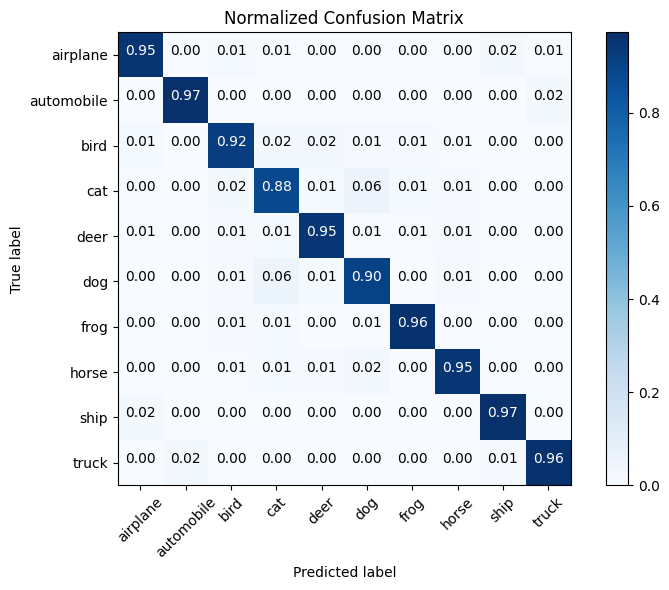

Classification Report:
              precision    recall  f1-score   support

    airplane       0.94      0.95      0.95      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.93      0.92      0.92      1000
         cat       0.87      0.88      0.88      1000
        deer       0.93      0.95      0.94      1000
         dog       0.90      0.90      0.90      1000
        frog       0.96      0.96      0.96      1000
       horse       0.97      0.95      0.96      1000
        ship       0.96      0.97      0.97      1000
       truck       0.97      0.96      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



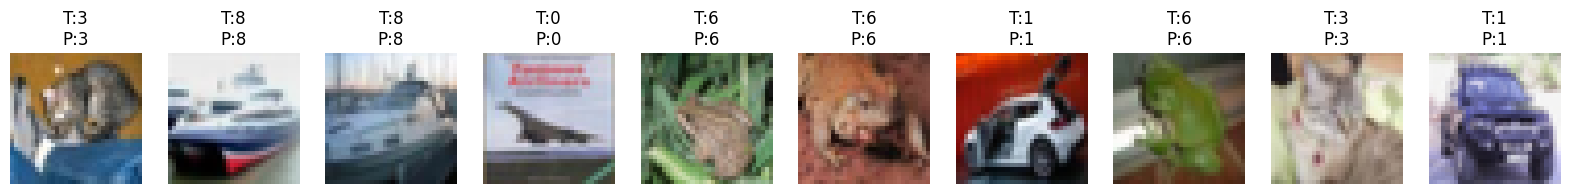

In [32]:
# -------------------- Additional Code for Visualization and Performance Evaluation --------------------

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Evaluate final performance on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")

# Compute predictions and true labels for the entire test set
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_targets, all_preds)
class_names = trainset.classes  # CIFAR-10 class names

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    Plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

# Print classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names))

# Visualization: Display sample predictions from the test set
def visualize_predictions(model, test_loader, device, num_images=10):
    """
    Visualizes a set of sample images along with their true and predicted labels.
    """
    model.eval()
    images, labels, preds = [], [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            images.extend(inputs.cpu())
            labels.extend(targets.cpu())
            preds.extend(predicted.cpu())
            if len(images) >= num_images:
                break

    fig, axes = plt.subplots(1, num_images, figsize=(num_images*2, 4))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"T:{labels[i]}\nP:{preds[i]}")
        axes[i].axis("off")
    plt.show()

visualize_predictions(model, test_loader, device, num_images=10)
